### Enhancing The Quality of Historical Simulations

이 섹션에서는 데이터 품질, 데이터 대표성, 통계 무결성, 모델링 및 일반화, 비용 및 제약 조건, 성능 평가 등의 과제를 제시하는 것으로 알려진 6가지 영역에 초점을 맞추어 백테스트의 품질을 높이는 방법에 대해 논의한다.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = yf.download('SPY', start = '2020-01-01', progress = False)

In [2]:
# Simple Momentum Strategy
data['SMA_5'] = data['Close'].rolling(window = 5).mean()
data['SMA_20'] = data['Close'].rolling(window = 20).mean()

data['Signal'] = 0
data.loc[data['SMA_5'] > data['SMA_20'], 'Signal'] = 1
data.loc[data['SMA_5'] < data['SMA_20'], 'Signal'] = -1
data['Position'] = data['Signal'].shift(1)

data['Strategy_Return'] = data['Position'] * data['Close'].pct_change()
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

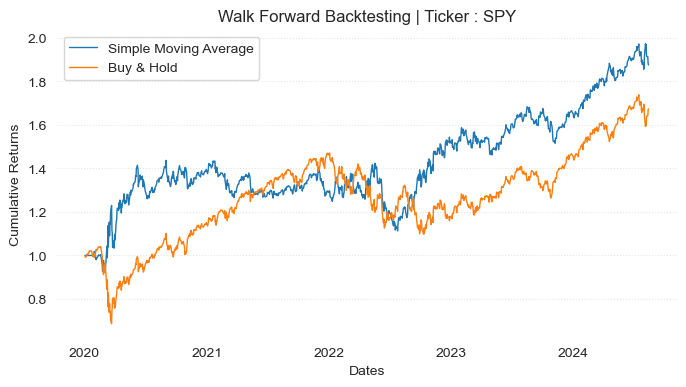

In [3]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(data['Cumulative_Strategy_Return'], lw = 1, label = 'Simple Moving Average')
ax.plot((1 + data['Close'].pct_change()).cumprod(), lw = 1, label = 'Buy & Hold')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Walk Forward Backtesting | Ticker : SPY')
plt.xlabel('Dates')
plt.ylabel('Cumulative Returns')
plt.show()

#### Data Quality

##### 1. Survivorship Bias

역사적으로 생존한 증권들에 대해서만 분석을 수행하고 그렇지 않은 데이터는 무시할 때 발생하는 선택 편향을 Survivorship Bias라고 정의한다. 일반적으로 상장폐지되거나 거래정지된 증권은 생존하여 거래가 지속되는 증권과 중요한 차이가 있기 때문에 이러한 편향은 왜곡된 결과를 초래하고 잘못된 결론을 도출할 수 있다. 

Surivorship Bias의 영향은 특히 Mutual Funds 및 Hedge Funds 성과 분석과 투자 전략에서 두드러진다. 예를 들어, 기간 말에 여전히 활동 중인 펀드만 포함하면 가장 실적이 좋지 않은 펀드들이 폐업하고 보고되지 않기 때문에 펀드 성과들을 크게 과대평가할 수 있다.

##### 2. Point-in-Time Considerations and Restated Data

Point in time은 분석이나 백테스팅에 사용된 데이터가 해당 시점에 연구자가 사용할 수 있었을 정보를 반영하였는지 확인하는 것을 의미한다. 이는 특히 오류, 회계 변경 또는 새로운 회계 기준 준수로 인해 수익 혹은 기타 재무 지표와 같이 이전에 보고된 재무 수치에 대한 조정이 포함된 조정된 데이터와 같은 경우와 관련이 있다. 재작성은 과거 재무제표를 크게 변경하여 재무 분석의 정확성과 해당 재무제표에 의존하는 모델에 영향을 미칠 수 있다. 실무자의 경우 재작성된 데이터를 신중하게 관리하는 것이 필수적이며, 이는 종종 사후에 수정되거나 조정되지 않고 원래 보고된 대로 재무 데이터를 사용하기 위해 그 당시에 가용 가능했던 데이터베이스를 사용하는 것을 의미한다.

##### 3. Incorrect and Missing Data

Incorrect data는 데이터 세트의 모든 오류 또는 부정확성이다. 이러한 부정확성은 데이터 입력 오류, 데이터 수집 방법의 문제 또는 데이터 전송 문제와 같은 다양한 원에서 비롯될 수 있다. 분석 전에 데이터를 철저히 관리해야 한다. 여기에는 오류를 확인하고, 수정하고, 데이터 세트 간 일관성을 보장하며, 신뢰할 수 있는 출처에 대해 데이터 정확성을 확인하는 것을 포함한다.

Missing data는 데이터 세트에 정보가 없는 것을 의미한다. 이는 시스템 오류, 데이터 손상 또는 데이터가 기록되거나 수집되지 않은 경우와 같은 다양한 이유로 발생할 수 있다. 누락된 값은 평균값 보간, 회귀모형을 사용한 보간과 같은 다양한 통계 기법 또는 MIDAS, ML 기반 접근법과 같은 보다 정교한 방법을 사용하여 보간할 수 있다. 맥락에 따라서는 보간을 통해 복잡성이 증가하는 것을 피하기 위해 `ffill()`과 같은 순방향 보간법이 좋은 선택이 될 수 있다. 경우에 따라 누락된 데이터는 대체 데이터 소스로부터 보간될 수 있지만, 이 접근법은 대체 데이터의 호환성과 신뢰성을 보장하기 위해 신중한 고려가 필요하다.

##### 4. Dealing with Outliers

투자 전략을 개발할 때에는 데이터 중에서 다른 데이터들에 비해 수치가 크게 벗어나는 극단값, 즉 이상치의 역할을 평가하는 것이 필수적이다. 이상치가 고유하고 반복되지 않는 사건을 나타낼 수 있기 때문에 이러한 희귀한 사건을 활용하는 전략은 지속 불가능할 수 있다. 결과적으로 이러한 이상치에 의존하면, 특정 조건에서는 예외적으로 잘 수행되지만 다양한 시장 환경에서 일반화되지 못하는 전략을 만들 수 있다.

Linear Regression과 같이 이상치에 본질적으로 민감한 모형을 통합할 때에는 이러한 극단적인 데이터 포인트의 특성과 영향에 주의를 기울여야 한다. 실무자는 이상치가 재무 수치가 잘못 보고되었는지와 같은 데이터 수집 또는 입력의 오류에서 발생한 것인지, 아니면 가치 있는 insight를 제공할 수 있는 실제 시장 현상을 반영하는 것인지 확인해야 한다.

#### Data Representativeness

Sample Periods Selection Bias는 데이터 대표성 영역에서 가장 중요한 관심사이다. 이러한 유형의 편향은 백테스트를 위해 선택한 시간 영역이 의도치 않게 결과에 영향을 미치면서 다양한 시장 조건 또는 기간에 걸쳐 강건하지 않을 수 있는 결론으로 이어질 때 발생한다. All weather Portfolio 투자 전략을 설계할 때, 최적의 성과를 내는 기간만 포함하는 것이 아니라 광범위한 시장 조건의 데이터를 포함하는 것이 필수적이다(Lopez de Prado, 2019). 이는 다양한 시장 주기에 걸쳐 전략의 견고성을 보장한다. 그러나 Lopez de Prado(2019a)가 설명한 바와 같이, 전술적 투자 전략을 수립할 때 특정 시장 조건에 맞게 설계된 경우 목표 시간 프레임을 선택하는 것이 더 적합할 수 있다. Bailey & Lopez de Prado(2012)가 설명한 Min-Track-Record-Length 알고리즘은 다양한 시장 시나리오에서 전략의 효과를 검증하는 데 필요한 관측치의 개수를 결정하는 데 도움이 될 수 있다.

#### Statistical Integrity

##### 1. Data Mining and Data Snooping

Data Mining과 Data Snooping의 개념은 투자 전략을 개발하는 데 사용할 수 있는 패턴, 관계 및 추세를 식별하기 위해 대규모 데이터 세트를 탐색하는 과정을 의미한다. 이러한 전략 개발 접근 방식은 통계적으로 중요한 것으로 보이는 데이터의 패턴을 찾아내는 데이터 분석 기술의 부적절한 적용을 통해 매우 쉽게 선택 편향을 초래하기 때문에 피해야 한다. Data Snooping(p-value hacking)은 연구자가 의미 있는 결과를 얻을 때까지 데이터의 다양한 하위 집합을 반복적으로 탐색하거나 (가능하면 동일한 데이터에 대해) 수많은 테스트를 수행하는 것을 포함한다(White 2000; Sullivan, Timmermann 및 White 1999).

##### 2. Accounting for Selection Bias under Multiple Testing

백테스팅은 성능 지표에 discount measure를 적용할 수 있도록 시행 회수와 해당 통계를 고려해야 한다(Lopez de Prado 2018, 2020). 이에 대해서는 다음 절에서 자세히 설명한다.

#### Modelling and Generalisation

##### 1. Look-Ahead Bias

미래의 데이터를 마치 그 때 당시에 사용할 수 있는 데이터처럼 사용하여 투자를 결정하는 실수가 바로 Look ahead Bias이다. 이를 연구 과정 때문에 정의하면서 당시 시점 데이터를 데이터를 사용하지 않는 문제와는 구분한다. 이러한 접근 방식은 투자 전략의 수익성에 대한 성과 지표와 비현실적인 기대를 부풀릴 수 있다. 일반적으로 이 오류는 지표나 신호에 적절한 지연을 적용하지 않음으로써 발생한다. 롤링 계산이 아닌 전체 데이터 샘플에 대한 통계를 계산할 때도 일반적으로 발생한다. 예를 들어 Z-Score의 평균과 표준 편차를 계산하여 신호를 정규화할 때 전체 샘플을 사용하는 것이 있다.

##### 2. Introducing an Embargo Period

통상적으로 Embargo Period는 최근 2~3년간 데이터의 Hold Out 샘플인 테스트 세트를 말한다. 실무자는 In sample을 기반으로 Trading Rule에 대해 모델을 적합시키고 설계 결정을 내려야 하며, 전략이 검증될 준비가 되면 Embargo Period 동안의 결과를 도출할 수 있다. 또한 Train Set에서 악용된 모든 Market Anomaly 현상도 Embargo Period에 존재해야 한다.

#### Costs and Constraints

거래 비용과 공매도 및 유동성과 관련된 조건들을 고려하는 것은 일반적으로 간과되는 단계이다. 이번 절에서는 이와 관련된 주제를 다룬다.

##### 1. Transaction Costs

거래 비용에 대한 설명을 소홀히 하면 거짓 전략을 발견할 확률이 높아진다. Turnover가 높은 전략은 더 큰 비용을 발생시키며, 실행 가능하기 위해서는 더 큰 수익을 요구한다. 이러한 비용을 평가에서 누락하면 성과 지표가 부풀려진다.

Borkevc와 Heidle(2010)은 비용의 유형과 거래에 미치는 영향에 대해 언급했다. 특히 이들은 비용을 세 가지 유형으로 나누었다. 
첫째, Brokerate Costs는 과거 데이터를 사용하여 쉽게 추정할 수 있으며 fee와 Commission을 포함한다. 이 중 fee의 두 가지 예로는 보관 및 이전 수수료가 있다. 
둘째, Trading Costs은 Delay Costs, Bid-Ask Spread, Market volatility/trend costs, Market Impact의 네 가지 구성요소로 구성된다. 
마지막으로 Opportunity Costs는 전체 주문을 완료하지 못한 경우 발생하는 비용이다. 저자들은 Market Impact는 가장 높은 비용(모형화하기 어렵고)을 가지는 반면 수수료와 스프레드는 가장 낮은 효과를 가지며 쉽게 추정된다는 점을 강조한다. 거래비용은 과거 데이터를 사용하여 경험적으로 또는 모형을 구축하려고 시도하여 분석적으로 추정할 수 있다.

1. Commissions

수수료는 브로커가 거래를 실행하는 데 부과하는 수수료이다. 이는 브로커의 가격 구조, 자산 클래스, 거래량에 따라 크게 다를 수 있다. 수수료는 거래당 고정 수수료, 거래 가치의 일정 비율, 또는 거래된 주식이나 계약의 수에 따라 부과될 수 있다

- Best practice
    - 브로커별 계산: 백테스트에서 수수료 구조가 실제 거래에 사용할 브로커의 구조를 반영하도록 한다
    - 단계적 구조: 브로커가 단계적 수수료 구조를 사용하는 경우, 백테스트에서 다양한 거래량 임계치에서 변동하는 요금을 고려한다
    - 전략에 대한 영향: 일일 거래나 고주파 거래와 같이 빈번한 거래를 포함하는 전략에 주의를 기울이며, 수수료 비용이 빠르게 누적되어 순수익에 상당한 영향을 미칠 수 있다

In [4]:
target_vol = 0.15 # volatility target

data['stdev'] = data['Close'].pct_change().rolling(22).std() * np.sqrt(252) # convert to annualized standard deviation
data['volatility_target'] = target_vol / data['stdev']

# Clip weights to a maximum of 1 to avoid leverage
# Here we use 2x leverage to make sure we can hit our volatility target of 15%
data['volatility_target'] = data['volatility_target'].clip(0, 2)

In [5]:
# Adjust the signal by the volatility target, lagging both to avoid look-ahead bias
vol_signal = data['Signal'].shift(1) * data['volatility_target'].shift(1)

# Compute returns for the volatility-targeted strategy
strategy_voltgt_returns = data['Close'].pct_change() * vol_signal

In [6]:
turnover = abs(vol_signal.diff())
# Shift by -1 to get the date at which the transaction occurred, which was at close yesterday.
turnover = turnover.shift(-1)

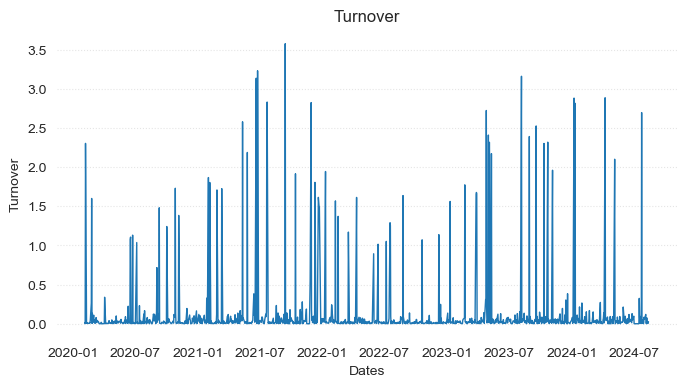

In [7]:
# Plot Turnover
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(turnover, lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Turnover')
plt.xlabel('Dates')
plt.ylabel('Turnover')
plt.show()

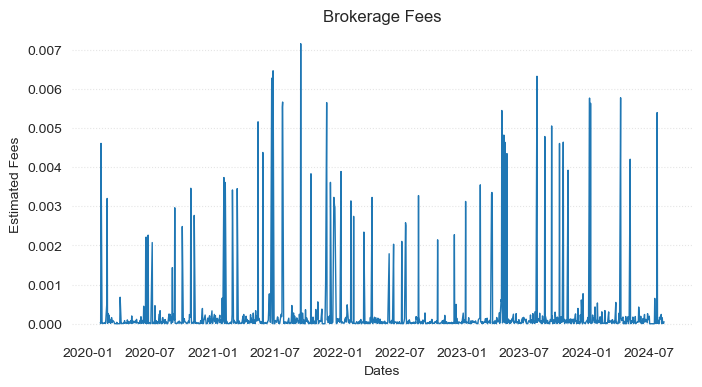

In [8]:
brokerage_fees = 0.0020 # 20 basis points
brokerage = turnover * brokerage_fees

# Plot Brokerage
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(brokerage, lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Brokerage Fees')
plt.xlabel('Dates')
plt.ylabel('Estimated Fees')
plt.show()

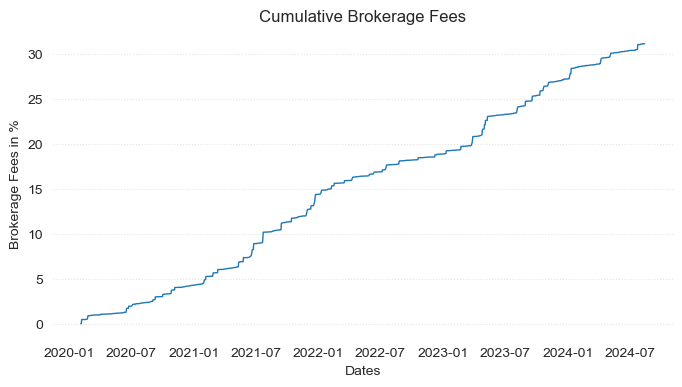

In [9]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(brokerage.cumsum() * 100, lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Cumulative Brokerage Fees')
plt.xlabel('Dates')
plt.ylabel('Brokerage Fees in %')
plt.show()

2. Bid-ask spread

매수-매도 스프레드는 구매자가 지불할 의향이 있는 가장 높은 가격(매수가)과 판매자가 받아들일 의향이 있는 가장 낮은 가격(매도가) 사이의 차이이다. 이 스프레드는 트레이더에게 비용이며, 스프레드가 더 넓은 유동성이 낮은 자산에 특히 중요하다

- Best practice
    - 역사적 스프레드: 전략에서 사용하는 자산의 평균 스프레드를 추정하기 위해 역사적 스프레드 데이터를 활용한다
    - 일중 거래: 일중 거래 전략의 경우, 거래일 내내 크게 변할 수 있는 스프레드 데이터를 사용한다
    - 자산 유동성: 유동성이 낮은 자산은 종종 더 넓은 스프레드를 가지며, 특히 큰 거래에서 이익을 침식할 수 있으므로 이를 고려한다

In [10]:
from FinancialMachineLearning.features.microstructure import bar_based_kyle_lambda
import warnings
warnings.filterwarnings('ignore')

spread = bar_based_kyle_lambda(
    close = data['Close'], 
    volume = data['Volume']
)

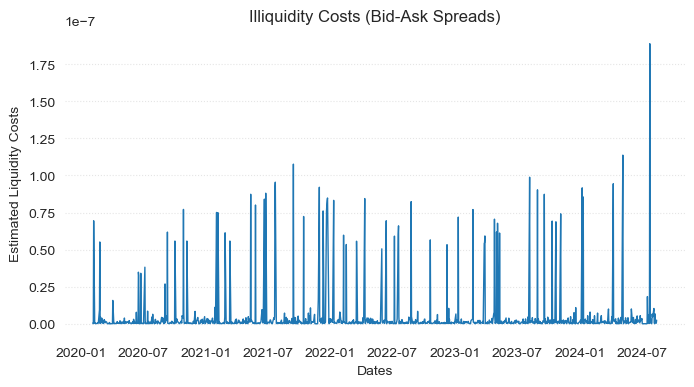

In [11]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(turnover * spread, lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Illiquidity Costs (Bid-Ask Spreads)')
plt.xlabel('Dates')
plt.ylabel('Estimated Liquidity Costs')
plt.show()

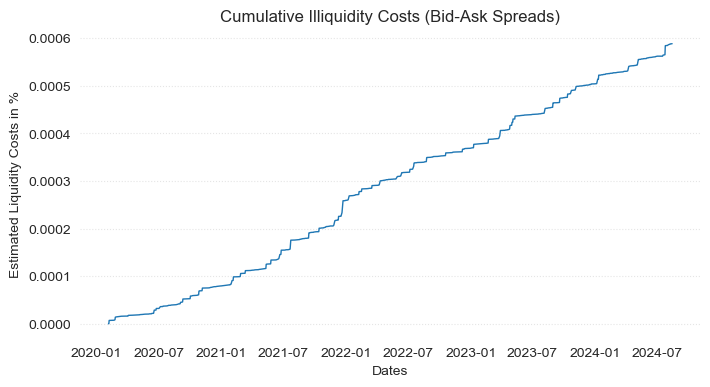

In [12]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot((turnover * spread).cumsum() * 100, lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Cumulative Illiquidity Costs (Bid-Ask Spreads)')
plt.xlabel('Dates')
plt.ylabel('Estimated Liquidity Costs in %')
plt.show()

3. Market impact

시장 영향은 트레이더의 주문이 자산의 시장 가격에 미치는 영향을 말한다. 특히 큰 주문의 경우, 트레이더의 활동이 시장 가격을 변화시켜 슬리피지(거래가 예상 가격과 실제 체결 가격 사이의 차이)를 발생시킬 수 있다

- Best practice
    - 크기가 중요합니다: 주문이 시장 거래량에 비해 상대적으로 클수록 잠재적인 시장 영향이 더 클 수 있다. 대규모 거래를 포함하는 전략에 이를 반영한다
    - 시장 영향 모델링: 선형 비용 모델이나 주문 크기의 제곱근에 비례한다고 제안하는 제곱근 모델과 같은 시장 영향 모델을 활용한다
    - 적응형 전략: 큰 주문을 작은 주문으로 나누거나 시장 상황에 적응하는 알고리즘 실행 전략과 같이 시장 영향을 최소화하는 전략을 고려한다

In [13]:
# Intergrating Slippage
daily_value = data['Volume'] * data['Close']

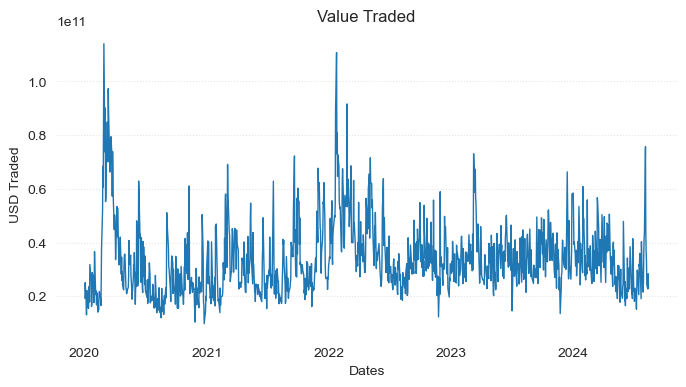

In [14]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(daily_value, lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Value Traded')
plt.xlabel('Dates')
plt.ylabel('USD Traded')
plt.show()

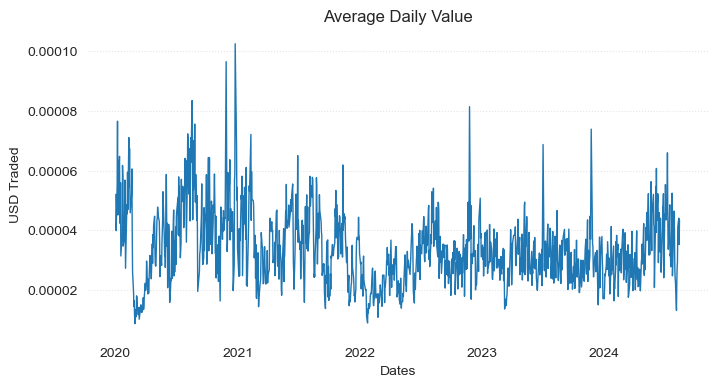

In [15]:
adv = 1000000 / daily_value

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(adv, lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Average Daily Value')
plt.xlabel('Dates')
plt.ylabel('USD Traded')
plt.show()

**Notes**

- 전체 슬리피지: 하루에 최대 100만 달러의 거래를 가정할 때 전체 기간에 걸쳐 25 베이시스 포인트 미만이다
- 벡터화된 백테스팅에서의 슬리피지 접근: 벡터화된 백테스팅은 계산 효율성을 제공하지만, 이 방법에서 상세한 슬리피지 계산을 생략하는 것이 일반적으로 권장된다. 그 이유는 벡터화된 백테스팅이 슬리피지를 정확하게 시뮬레이션하는 데 필요한 세부적인 정보를 제공하지 못하기 때문이다. 대신, 슬리피지는 for-loop이나 이벤트 기반 백테스팅 프레임워크 내에서 더 효과적으로 계산되며, 여기서 각 거래별로 더 정밀한 모델을 적용할 수 있다
- 유동성이 슬리피지에 미치는 영향: 유동성이 낮은 주식에서는 슬리피지가 더 두드러지는 경향이 있다. 이러한 경우, 상대적으로 작은 주문도 시장 가격에 상당한 영향을 미칠 수 있으며, 이는 거래의 예상 가격과 체결 가격 사이의 더 큰 격차로 이어진다. 이 요소는 유동성이 낮은 자산을 다루거나 자산의 거래 활동에 비해 큰 거래량을 포함하는 전략에 특히 중요하다

In [16]:
# Lets use this to compute slippage costs, linearly (This is not the Linear Model)
# If 1% = 10 basis points then every 10 basis points of ADV can be 1 basis point of slippage.
cost = (adv / 0.01) * 0.0010
slippage = cost * turnover

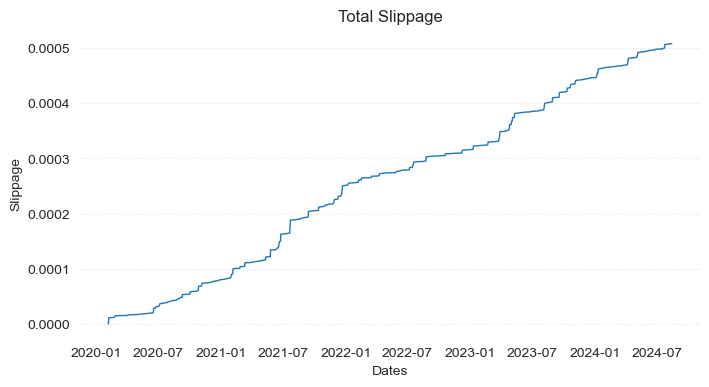

In [17]:
# Plot total slippage

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(slippage.cumsum(), lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Total Slippage')
plt.xlabel('Dates')
plt.ylabel('Slippage')
plt.show()

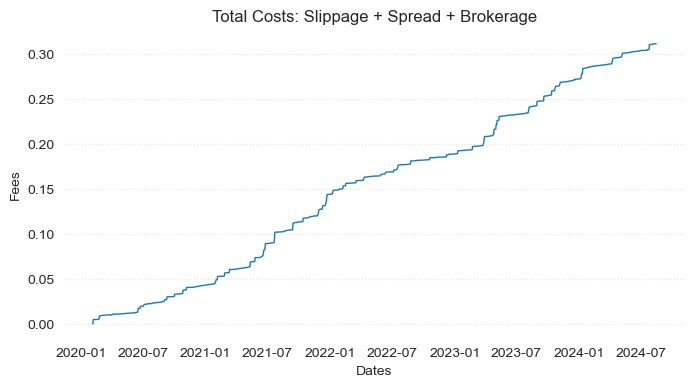

In [18]:
total_costs = brokerage + spread + slippage

# Plot total costs
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(total_costs.cumsum(), lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Total Costs: Slippage + Spread + Brokerage')
plt.xlabel('Dates')
plt.ylabel('Fees')
plt.show()

비용을 고려한 SMA 전략의 성과와 비용을 고려하지 않은 SMA의 전략의 성과를 비교해보면 꽤 차이가 심한 것을 알 수 있다.

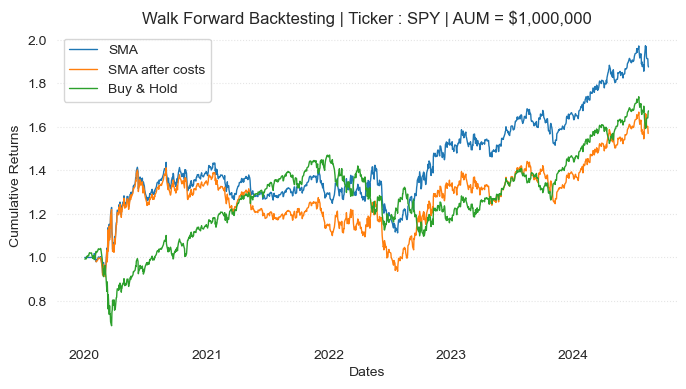

In [19]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(data['Cumulative_Strategy_Return'], lw = 1, label = 'SMA')
ax.plot(data['Cumulative_Strategy_Return'] - total_costs.cumsum(), lw = 1, label = 'SMA after costs')
ax.plot((1 + data['Close'].pct_change()).cumprod(), lw = 1, label = 'Buy & Hold')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Walk Forward Backtesting | Ticker : SPY | AUM = \$1,000,000')
plt.xlabel('Dates')
plt.ylabel('Cumulative Returns')
plt.show()

##### 2. Short-Sale Constraints

공매도를 실행할 때 주식을 빌리는 비용도 종종 간과된다. 브로커들이 이 비용들을 다른 서비스와 결합할 수 있기 때문에, 이러한 비용을 추정하는 것은 어려울 수 있다(Saffi and Sigurdsson 2011). 또한 공매도 수요가 증가함에 따라 주식을 공매도할 수 있는 가능성이 낮아진다. 금융위기 시, 몇몇 국가는 공매도를 제한할 수 있으며(특히 대한민국과 같은), 심지어 Uptick Rule과 같은 규제를 부과하는 국가도 있다(Boehmer, Jones and Zhang 2013). 칸(2024)은 이 주제에 대해 포괄적인 리뷰 논문을 제시한다.

##### 3. Liquidity Constraints

백테스팅에는 거래되는 상품의 유동성을 고려해야 한다. 일반적으로 거래는 각 증권의 일평균 거래량의 일정 비율로 제한된다. 이 제약은 거래의 실행이 시장 가격에 큰 영향을 미치지 않도록 하기 위해 가해진다.

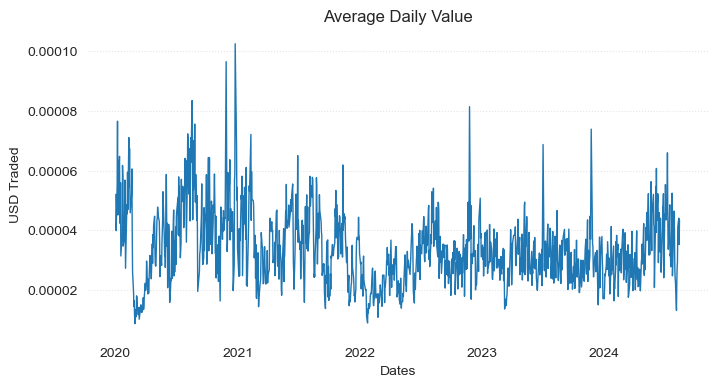

In [20]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(adv, lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Average Daily Value')
plt.xlabel('Dates')
plt.ylabel('USD Traded')
plt.show()

##### 4. Universe Selection

투자 유니버스를 신중하게 선택하면 유동성과 공매도 가용성의 영향을 제한하는 데 도움이 될 수 있다. 이 제약에는 시가총액이 5억 달러 이상이고, 일일 거래대금의 중간값이 500만 달러 이상, 가격이 6달러 이상이며, 가격 및 거래량 데이터가 500일인 거래 자산만 포함될 수 있다.

#### Performance Evaluation

##### 1. Causal Graphs

Narrative Fallacy는 Cognitive Bias를 포함하는데, 이는 실무자들이 일련의 사건에 대해 이야기와 같은 설명을 만들고, 종종 아무 관계가 없는 것에 인과 관계와 의미를 추가하는 것을 의미한다. 사건을 익숙한 구조에 맞추기 위한 선천적인 욕구로 인해 잘못 해석될 수 있다. 이를 방지하기 위해 Lopez de Prado(2023)와 Lopez de Prado and Zoonekynd(2024)는 한 번의 백테스트를 실행하기 전에 실무자들이 인과 관계 그래프와 사건 순서에 대한 설명을 생성하여 연구자의 이익을 위해 악용될 변칙을 설명할 것을 권장한다.

##### 2. Performance Metrics

거래 전략의 성과에 대한 일반적인 척도는 표준 편차(Risk)에 대한 무위험 이자율 대비 초과 수익의 비율로 정의되는 Sharpe Ratio(Sharpe, 1966)이다.

$$\text{SR} = \frac{\mu - r_f}{\sigma}$$

여기서 $\mu = E(r)$은 전략 혹은 증권의 기대 초과 수익률이고, $r_f$는 무위험이자율, 그리고 $\sigma$는 수익률의 표준편차이다. 즉, Sharpe Ratio는 위험 1단위당 전략의 수익률을 표현한다. 관측할 수 없는 parameter $\mu$와 $\sigma$는 지금까지 관측된 데이터를 이용해 계산되는데, $\bar{r} = \sum_{t=1}^T \frac{r_t}{T}$이고 $\hat{\sigma} = \sqrt{\frac{1}{T-1} \sum_{t=1}^T (r_t - \bar{r_t})^2}$으로 추정된다. 여기서 $T$는 샘플 사이즈를 의미한다.

Sharpe Ratio의 공식적인 정의는 초과 수익의 개념을 기반으로 하지만, 종종 $r_f = 0$이라는 암묵적인 가정 하에 보고된다. 또한 Sharpe Ratio는 일반적으로 연율화된 용어로 보고된다. 여기서는 위 식에 분자와 분모를 그에 따라 재조정하는 것이 포함된다.

추정된 Sharpe Ratio의 점근적 분포는 학계에서 상당한 관심을 끌었다. Lo(2002), Mertens(2002) 및 Christie(2005)는 정상성과 에르고딕 가정 하에서 Limiting Distribution을 도출했다. Mertens(2002)가 도출한 limiting variance에 대한 공식은 관측치가 독립적이고 동일하게 분포되지 않을 때 유지되는 것으로 나타났다. Ledoit and Wolf(2008), Liu, Rekas and Wong(2012) 및 Qi, Rekas 및 Wong(2018)의 Higher order accuracy를 보자. 점근적으로 추정된 Sharpe Ratio의 분포가 다음과 같이 주어진다.

$$\sqrt{T}\left( \widehat{\text{SR}} - \text{SR}\right) \rightarrow^d N \left( 0, 1 + \frac{1}{2}\text{SR}^2 -\gamma_3 \text{SR} + \frac{\gamma_4 - 3}{4}\text{SR}^2 \right) $$

여기서 $N$은 정규 분포를 따르는 변수이고, $\gamma_3$과 $\gamma_4$는 각각 수익률의 왜도와 첨도이다. 위 결과를 실현 가능하게 구현하려면 표본에 의한 한계 분산의 미지의 양을 추정해야 한다. 높은 초과 첨도 및/또는 음의 왜도를 나타내는 전략의 Sharpe Ratio는 덜 정확하게 추정된다. Bailey and Lopez de Prado(2012)는 위의 결과를 이용하여 $\text{PSR}$(Probabilistic Sharpe Ratio)을 다음과 같이 도출하였다.

$$\text{PSR}\left[ \text{SR}^*\right] = Z \left[ \frac{\left( \widehat{\text{SR}} - \text{SR}^* \right) \sqrt{T-1}}{\sqrt{1 - \widehat{\gamma}_3 \widehat{\text{SR}} + \frac{\widehat{\gamma}_4 - 1}{4} \widehat{\text{SR}}^2}}\right]$$

여기서 $Z$는 표준 정규 분포의 누적 분포함수, $\text{SR}^*$는 귀무 가설의 값, $T$는 관측치의 개수, $\gamma_3$은 추정된 왜도, $\gamma_4$는 추정된 첨도이다. $\text{PSR}$을 통해 연구자는 관측치 수, 왜도 및 첨도를 보정한 후 임계치 $\text{SR}^*$이상의 성과를 통계적으로 유의하게 관측할 확률로 Sharpe Ratio를 표현할 수 있다. $\text{PSR}$은 헤지 펀드의 경우 특히 유용하며, 수익률이 종종 음의 왜도와 양의 초과 첨도를 나타내므로 Sharpe Ratio가 부풀려지는 경향이 있다.


In [21]:
risk_free = yf.download(
    '^IRX',
    start = '2020-01-01', 
    progress = False
)['Close'] * 0.01 / 252

In [22]:
strategy_after_cost = data['Cumulative_Strategy_Return'] - total_costs.cumsum()
excess_return = strategy_after_cost.pct_change().dropna() - risk_free

In [23]:
obs_sr = (excess_return.mean() * 252) / (data['Cumulative_Strategy_Return'].pct_change().dropna().std() * np.sqrt(252)) # annualized strategy sharpe ratio

In [24]:
bench_sr = ((data['Close'].pct_change() - risk_free).mean() * 252) / (data['Close'].pct_change().std() * np.sqrt(252)) # annualized benchmark sharpe ratio

In [25]:
from FinancialMachineLearning.backtest.backtest_statistics import probabilistic_sharpe_ratio

str_skew = strategy_after_cost.pct_change().skew()
str_kurt = strategy_after_cost.pct_change().kurt()

psr = probabilistic_sharpe_ratio(
    observed_sr = obs_sr,
    benchmark_sr = bench_sr,
    number_of_returns = len(data['Cumulative_Strategy_Return'].pct_change().dropna()),
    skewness_of_returns = str_skew,
    kurtosis_of_returns = str_kurt 
)

In [26]:
print(f'Benchmark Sharpe Ratio(Buy and Hold) : {bench_sr : .4f}')
print(f'Observed Strategy Sharpe Ratio : {obs_sr : .4f}')
print(f'Probabilistic Sharpe Ratio : {psr * 100 : .2f}%')

Benchmark Sharpe Ratio(Buy and Hold) :  0.5195
Observed Strategy Sharpe Ratio :  0.5004
Probabilistic Sharpe Ratio :  28.11%


이와 관련해 Bailey와 Lopez de Prado(2012)는 $\text{MinTRL}$(Minimum Track Record Length) 통계량을 소개하기도 했다.

$$\text{MinTRL}\left[ \text{SR}^*\right] = 1 + \left( 
1 - \widehat{\gamma}_3\widehat{\text{SR}} + \frac{\widehat{\gamma}_4 - 1}{4} \widehat{\text{SR}}^2
\right) \left( 
\frac{Z_\alpha}{\widehat{\text{SR}} - \text{SR}^*}
\right)^2$$

여기서 $Z_\alpha$은 유의 수준 $\alpha$와 관련된 임계 값이다. $\text{MinTRL}$ 공식은 더 긴 Track Records가 필요하다는 것을 보여준다. $\widehat{\text{SR}}$이 작을수록, 또는 음의 방향으로 치우친 수익률이 작을수록, 또는 Fat tail이 클수록, 또는 필요한 신뢰 수준이 커야 한다는 것을 보여준다. 첫 번째 실용적 시사점은 Track Records가 $\text{MinTRL}$보다 짧으면, 관찰된 $\widehat{\text{SR}}$이 지정된 임계값인 $\text{SR}^*$보다 높다는 충분한 확신을 갖지 못한다는 것이다. 두 번째 실용적 시사점은 포트폴리오 매니저(PM)가 비정상 수익률로 인해 불이익을 받지만, PM은 시간이 지남에 따라(Track Records 길이를 연장함으로써) 투자자의 신뢰를 되찾을 수 있다는 것이다.

In [27]:
# Z(0.95) = 1.645
min_trl = 1 + (1 - (str_skew * obs_sr) + (((str_kurt + 2) / 4) * (obs_sr ** 2))) * ((1.645 / (obs_sr - bench_sr)) ** 2)

In [28]:
print(f'Minimum Track Record Length : {min_trl : .2f}')

Minimum Track Record Length :  10732.50


Sharpe Ratio는 성과 측정치로 널리 사용됨에도 불구하고 몇 가지 잘 알려진 한계가 있다. 수익률이 Normal Distribution을 따르는 유동적인 자산에는 적합하지만, 수익률이 비선형적인 파생상품을 사용하는 것을 포함하는 수익률이 매우 비정상적인 분포를 가진 경우에는 덜 적합할 수 있다. 이로 인해 실무자들은 수익률 분포의 왼쪽 꼬리에 주로 초점을 맞춘 측정치를 계산하는 통계량을 보완하게 되었다. 이는 다음과 같은 것들이 존재한다.

1. Maximum Drawdown

$$\max_{\tau \in (0, \tau)} \left[ 
\frac{ \max_{t \in (0, \tau)} X_t - X_{\tau} }{ \max_{t \in (0, \tau)} X_t }
\right]$$

여기서 $X_t$는 투자중인 자산의 현재 가치를 의미한다.

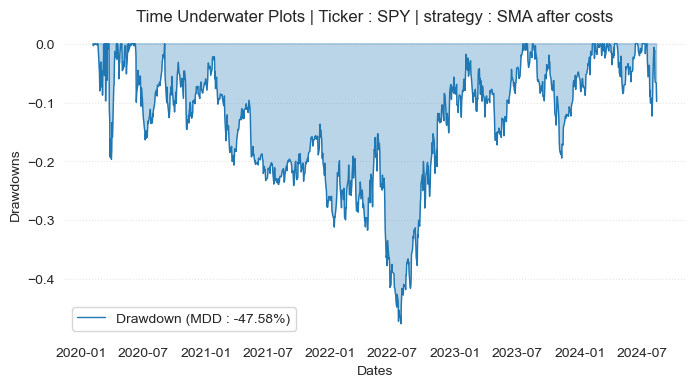

In [29]:
drawdown = strategy_after_cost - strategy_after_cost.cummax()
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(
    drawdown, 
    lw = 1, 
    label = f'Drawdown (MDD : {drawdown.min() * 100 : .2f}%)'
)
ax.fill_between(
    drawdown.index, 
    drawdown, 0, 
    where = (drawdown < 0), 
    color = 'tab:blue', 
    alpha = 0.3
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Time Underwater Plots | Ticker : SPY | strategy : SMA after costs')
plt.xlabel('Dates')
plt.ylabel('Drawdowns')
plt.show()

2. 특정한 임계치 $\alpha$(보통 5% 혹은 1%를 사용한다)에서의 $\text{VaR}$ 추정치. 일반적으로 다음과 같이 정의된다.

$$\text{VaR}_\alpha (X) = \min (c : P(X \leq x) \geq \alpha)$$

여기서 $X$는 손실과 관련된 random variable이다.

In [30]:
sorted_returns = strategy_after_cost.pct_change().dropna().sort_values()

In [31]:
alpha = 0.95
idx = int((1 - alpha) * len(sorted_returns))

VaR = sorted_returns.iloc[idx]

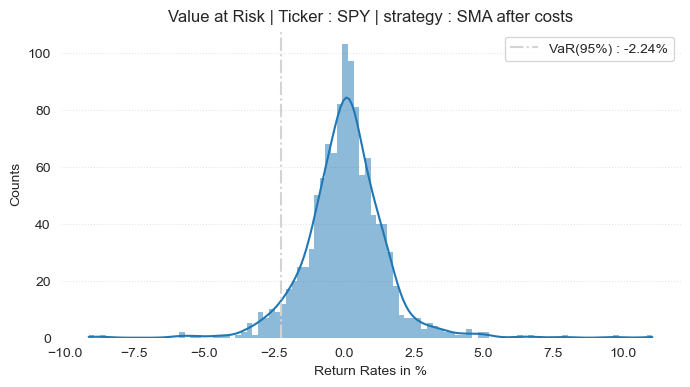

In [32]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (8, 4))
sns.histplot(
    sorted_returns * 100, 
    edgecolor = 'none',
    kde = True,
    bins = 100
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(VaR * 100, color = 'lightgray', ls = '-.', label = f'VaR(95%) : {VaR * 100 : .2f}%')
plt.legend()
plt.title('Value at Risk | Ticker : SPY | strategy : SMA after costs')
plt.xlabel('Return Rates in %')
plt.ylabel('Counts')
plt.show()

3. 특정 임계치 $\alpha$에서의 Conditional Value at Risk($\text{cVaR}$)

$$\text{cVaR}_\alpha (X) = E(X | X \geq \text{VaR}_\alpha (X))$$

In [33]:
cVaR = sorted_returns[sorted_returns <= VaR].mean()

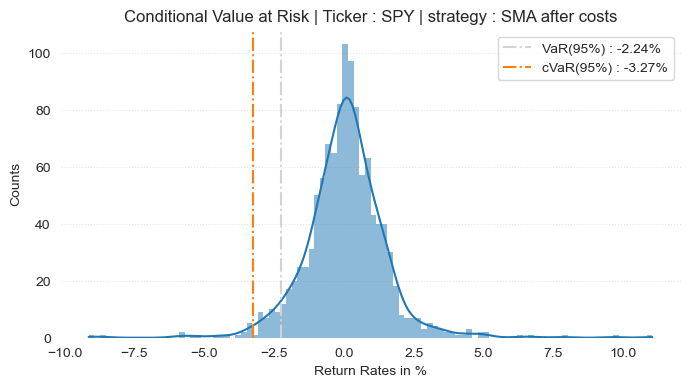

In [34]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.histplot(
    sorted_returns * 100, 
    edgecolor = 'none',
    kde = True,
    bins = 100
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(VaR * 100, color = 'lightgray', ls = '-.', label = f'VaR(95%) : {VaR * 100 : .2f}%')
plt.axvline(cVaR * 100, color = 'tab:orange', ls = '-.', label = f'cVaR(95%) : {cVaR * 100 : .2f}%')
plt.legend()
plt.title('Conditional Value at Risk | Ticker : SPY | strategy : SMA after costs')
plt.xlabel('Return Rates in %')
plt.ylabel('Counts')
plt.show()

4. Calmar Ratio, 이는 연평균 수익률과 MDD간의 비율로 계산한다.

In [35]:
calmar_ratio = (excess_return.mean() * 252) / drawdown.min()
print(f'Calmar Ratio : {calmar_ratio * 100 : .2f}%')

Calmar Ratio : -22.71%


5. Sortino Ratio, 평균 수익률과 하방 리스크간의 비율로 계산한다.

In [36]:
def get_sortino_ratio(returns, risk_free_rate, annualized = False):
    excess_returns = returns - risk_free_rate
    downside_risk = np.sqrt(np.mean(np.minimum(excess_returns, 0) ** 2))
    mean_excess_return = np.mean(excess_returns)
    sortino_ratio = mean_excess_return / downside_risk
    if annualized : 
        sortino_ratio = sortino_ratio * np.sqrt(252)
    return sortino_ratio

sortino_ratio = get_sortino_ratio(strategy_after_cost.pct_change(), risk_free, annualized = True)

In [37]:
print(f'Sortino Ratio : {sortino_ratio : .4f}')

Sortino Ratio :  0.6756


Favre and Galeano(2002)와 Gregoriou and Guueyie(2003)는 수정된 Sharpe Ratio를 제안했는데, 여기서 기존의 Sharpe Ratio의 분모는 $\text{VaR}_\alpha$로 대체된다. Ardia and Boudt(2015)는 두 전략의 수정된 Sharpe Ratio을 비교하는 테스트를 개발하였다.

##### 3. Holistic Evaluation of Metrics

성과 분석은 재무 회계 비율 분석과 마찬가지로 전체적으로 수행되어야 하며, 정보에 입각한 의사 결정을 내리기 위해서는 여러 성과 지표를 함께 고려해야 한다는 점을 강조한다. 이 원칙을 무시하는 대표적인 예는 위험 조정 수익률이나 Drawdowns / Time Under water를 고려하지 않고 연간 수익률만 살펴보는 것이다.


##### 4. Peer Review

독립적인 Peer Review Process는 검토자가 버그에 대한 소스 코드를 확인하고 연구자의 주장을 검증하며 사용된 방법론을 비판함에 따라 True Positive를 발견할 가능성을 더욱 높일 수 있다(Bailey and Lopez de Prado 2014; Harvey and Liu 2015). 검토자는 여러 테스트를 통제하면서 진정한 Sharpe Ratio가 통계적으로 유의한지 확인하기 위해 통계 검정을 실행할 수도 있다(Bailey and Lopez de Prado 2014; Harvey and Liu 2015).